<a href="https://colab.research.google.com/github/tmtakashi/machine_learning_notebooks/blob/master/RNN_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
% cd /content/drive/My Drive/Colab Notebooks/fusic/RNN

/content/drive/My Drive/Colab Notebooks/fusic/RNN


# RNNまとめ

## Simple RNN

### RNNレイヤの順伝搬
- $\bf h_t = \tanh(\bf h_{t-1}\bf W_h + \bf x_t\bf W_x +\bf b)$
  - $\bf W_x: $入力$\bf x_t$を現時刻の出力$\bf h_t$に変換する重み
  - $\bf W_h: $ひとつ前の時刻の出力$\bf h_{t-1}$を現時刻の出力$\bf h_t$に変換する重み
  - $\bf h_t$は隠れ状態ベクトル(hidden state vector)とよばれることが多い
- stateful : 隠れ状態を維持し、順伝搬を断ち切ることなく伝搬させる
  - 利点：ネットワークが小さく、学習時間が短い
  - 欠点：データの周期性を反映するバッチサイズを選ぶ必要がある
  - ほとんどの問題はstatelessで解ける。データが周期性を示す場合にはstatefulにする必要あり。

### RNNレイヤの逆伝搬
- Backpropagation Through Time(BPTT)
  - 長い時系列データを扱う際に計算リソース、メモリが足りなくなる
- Truncated BPTT
  - ネットワークを適当な長さで切る
  - 小さなネットワークを複数つくり、それぞれで誤差逆伝搬法をおこなう
  - 順伝搬のつながりは切断しない
- ミニバッチ学習
  - 通常のネットワークのように完全にランダムではダメ。シーケンシャルに与える必要がある。
  - 例えば長さ1000の時系列データであれば$\left(
    \begin{array}{ccc}
      x_0 & x_1 & ... &x_9  \\
      x_{500} & x_{501} & ... &x_{509} 
    \end{array}
  \right)$
  のように各バッチの開始位置をずらして入力

In [0]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next **2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(dt, Wh.T)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

シンプルな言語モデル
- Embedding => RNN => Dense => Softmax

###  Simple RNNを用いたテキスト生成
- 「不思議の国のアリス」(Alice in Wonderland)のテキストを用いて学習
https://www.gutenberg.org/files/11/11-0.txt
- 学習を高速にするために文字ベースの言語モデルを学習

In [0]:
from keras.layers import Dense, Activation, SimpleRNN
from keras.models import Sequential
import numpy as np
import codecs

INPUT_FILE = './data/alice_in_wonderland.txt'

with codecs.open(INPUT_FILE, "r", encoding="utf-8") as f:
  lines = [line.strip().lower() for line in f  
               if len(line) != 0]
  text = " ".join(lines)


In [0]:
# 文字のルックアップテーブルを作成
chars = set(text)
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [0]:
# 入力テキストおよびラベルテキストの作成
SEQLEN = 10
STEP = 1

input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
  input_chars.append(text[i:i + SEQLEN])
  label_chars.append(text[i + SEQLEN])

In [0]:
for input, label in zip(input_chars[:10], label_chars[:10]):
  print(input, ' -> ', label)

﻿project g  ->  u
project gu  ->  t
roject gut  ->  e
oject gute  ->  n
ject guten  ->  b
ect gutenb  ->  e
ct gutenbe  ->  r
t gutenber  ->  g
 gutenberg  ->  ’
gutenberg’  ->  s


In [0]:
# 入力テキストとラベルテキストのベクトル化、one-hotで表現
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
  for j, ch in enumerate(input_char):
    X[i, j, char2index[ch]] = 1
  y[i, char2index[label_chars[i]]] = 1

In [0]:
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH =100

model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=False,  # 単一の文字を返す
                   input_shape=(SEQLEN, nb_chars),
                   unroll=True)) # TensorFlowバックエンドのパフォーマンス向上
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

for iteration in range(NUM_ITERATIONS):
  print("=" * 50)
  print("Iteration #: %d" % (iteration))
  model.fit(X, y, batch_size=BATCH_SIZE,
           epochs=NUM_EPOCHS_PER_ITERATION)
  
  test_idx = np.random.randint(len(input_chars))
  test_chars = input_chars[test_idx]
  print("Generating from seed: %s" % (test_chars))
  print(test_chars, end="")
  for i in range(NUM_PREDS_PER_EPOCH):
    Xtest = np.zeros((1, SEQLEN, nb_chars))
    for i, ch in enumerate(test_chars):
      Xtest[0, i, char2index[ch]] = 1
    pred = model.predict(Xtest, verbose=0)[0]
    ypred = index2char[np.argmax(pred)]
    print(ypred, end="")
    test_chars = test_chars[1:] + ypred
  print()

Iteration #: 0
Epoch 1/1
162739/162739 [==============================] - 14s 88us/step - loss: 2.3783
Generating from seed: e gryphon 
e gryphon the mand an the meree so the the soute the she sout an the maste so the soo to the soo to the soo to
Iteration #: 1
Epoch 1/1
162739/162739 [==============================] - 8s 49us/step - loss: 2.0639
Generating from seed: change, bu
change, but the ground the said the dont ou do the the said the dont ou do the the said the dont ou do the the
Iteration #: 2
Epoch 1/1
162739/162739 [==============================] - 8s 49us/step - loss: 1.9544
Generating from seed: ed tone.  
ed tone.  ‘the was she was she was she was she was she was she was she was she was she was she was she was she
Iteration #: 3
Epoch 1/1
162739/162739 [==============================] - 8s 49us/step - loss: 1.8713
Generating from seed: cated also
cated also the was so don the grople she had so don the grople she had so don the grople she had so don the gr
Iteration #: 4


- RNNの出力次元は実験してチューニングする必要がある
  - 次元が小さすぎると自然なテキストを生成できない
  - 次元が大きすぎると学習コストがかかる

## ゲート付きRNN
- Simple RNNは性能があまり良くない
  - 時系列データの長期の依存関係をうまく学習できないため
- 現在ではLSTMやGRUが使われる
  - 単にRNNというときはLSTMを指すときが多い
  - 「ゲート」と呼ばれる仕組みで時系列データの長期的な依存関係を学習できるようにする

### 勾配消失・勾配爆発
- 例文："Tom was watching TV in his room. Mary came into the room. Mary said hi to [ ? ]"
- 逆伝搬する際に勾配が途中で弱まると重みが更新されなくなる
  - 原因
    1. tanhノードを逆伝搬すると、微分が0~1の値しか取らない。-> 時間が長くなればなるほど勾配がどんどん小さくなる。
      - ReLUを用いて性能向上した例もある。
        - Improving performance of recurrent neural network with relu nonlinearity https://arxiv.org/pdf/1511.03771.pdf
    2. Matmul（行列の積）ノードの逆伝搬を計算する際は$dhW^T_h \cdots W^T_h$と、毎回同じ重みを掛け算していく。
      - http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/

249.495615421267


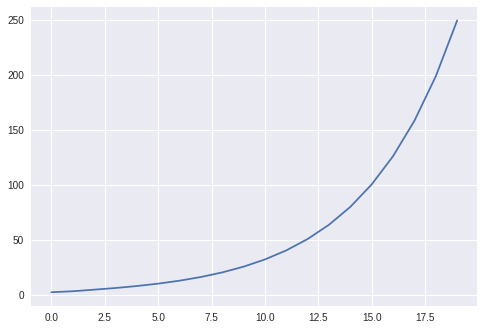

In [0]:
# 20回Whを掛け算していくとどうなるか？

import numpy as np
import matplotlib.pyplot as plt

N = 2 # ミニバッチサイズ
H = 3 #隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)

plt.plot(norm_list)

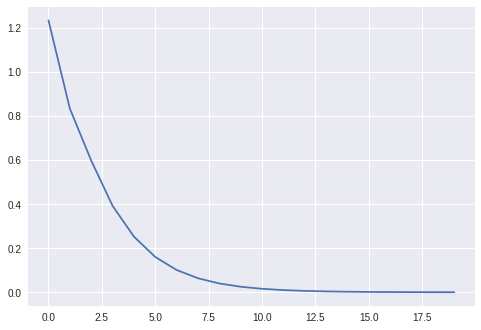

In [0]:
# 20回Whを掛け算していくとどうなるか？

import numpy as np
import matplotlib.pyplot as plt

N = 2 # ミニバッチサイズ
H = 3 #隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H))
np.random.seed(3)
Wh = 0.5 * np.random.randn(H, H) # 初期値を半分にしてみる

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)

plt.plot(norm_list)

### 勾配爆発・消失への対策
- 勾配爆発
  - 勾配クリッピング
  - $\begin{eqnarray}
    if  ||\hat g|| \geq threshold:\\
      \hat g = \frac{threshold}{||\hat g||}\hat g
   \end{eqnarray}$
- 勾配消失
  - LSTM, GRU

### LSTM
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- 活性化関数
  - ゲート：sigmoid (0~1、どれだけ通すか)
  - 情報 ：tanh (-1~1、情報を圧縮)
- 記憶セル $\bf c$
  - LSTMレイヤ内で受け渡しをする
  - 外部からは見えない
  - 隠れ状態$\bf h$は別のレイヤにも受け渡しをする
- outputゲート
  - 次の隠れ状態$\bf h_t$の出力を司る
  - 入力$\bf x_t$と前の隠れ状態$\bf h_{t-1}$から求める
    - $\bf o = \sigma (\bf x_t\bf W^{(o)}_x + \bf h_{t-1}\bf W^{(o)}_h + \bf b^{(o)})$
    - $\sigma$ :シグモイド関数
  - $h_t = \bf o \odot \tanh(\bf c_t)$
- forgetゲート
  - 記憶セルに対して「何を忘れるか」を明示的に指示
  - $\bf c_{t-1}$の記憶から不要な記憶を忘れさせる
  - $\bf f = \sigma (\bf x_t\bf W^{(f)}_x + \bf h_{t-1}\bf W^{(f)}_h + \bf b^{(f)})$
- 新しい記憶セルに付加する情報
  - 「情報」を付加 => tanhを使用
  - $\bf g = \tanh (\bf x_t\bf W^{(g)}_x + \bf h_{t-1}\bf W^{(g)}_h + \bf b^{(g)})$
- inputゲート
  - $\bf g$に対してのゲート
  - $\bf i = \sigma (\bf x_t\bf W^{(i)}_x + \bf h_{t-1}\bf W^{(i)}_h + \bf b^{(i)})$
  - $\bf c_t = \bf f \odot \bf c_{t-1}+ \bf g \odot \bf i$
- 勾配消失を起こさない理由
  - 記憶セルに注目
    - 加算ノードは上流からの勾配をそのまま伝えるだけ
    - forgetゲートが記憶セルの各要素の重要性をコントロールしている（要素ごとの積によるもの）
      - 忘れるべき要素の勾配は小さく、覚えるべき要素の勾配はそのまま伝搬

####  LSTMを用いたテキスト生成
- Simple RNNと比べるとlossが若干下がっている。


In [0]:
from keras.layers import Dense, Activation, LSTM
from keras.models import Sequential
import numpy as np
import codecs

INPUT_FILE = './data/alice_in_wonderland.txt'

with codecs.open(INPUT_FILE, "r", encoding="utf-8") as f:
  lines = [line.strip().lower() for line in f  
               if len(line) != 0]
  text = " ".join(lines)

In [0]:
# 文字のルックアップテーブルを作成
chars = set(text)
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [0]:
# 入力テキストおよびラベルテキストの作成
SEQLEN = 10
STEP = 1

input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
  input_chars.append(text[i:i + SEQLEN])
  label_chars.append(text[i + SEQLEN])

In [0]:
# 入力テキストとラベルテキストのベクトル化、one-hotで表現
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
  for j, ch in enumerate(input_char):
    X[i, j, char2index[ch]] = 1
  y[i, char2index[label_chars[i]]] = 1

In [0]:
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH =100

model = Sequential()
model.add(LSTM(HIDDEN_SIZE, return_sequences=False,  # 単一の文字を返す
                   input_shape=(SEQLEN, nb_chars),
                   unroll=True)) # TensorFlowバックエンドのパフォーマンス向上
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

for iteration in range(NUM_ITERATIONS):
  print("=" * 50)
  print("Iteration #: %d" % (iteration))
  model.fit(X, y, batch_size=BATCH_SIZE,
           epochs=NUM_EPOCHS_PER_ITERATION)
  
  test_idx = np.random.randint(len(input_chars))
  test_chars = input_chars[test_idx]
  print("Generating from seed: %s" % (test_chars))
  print(test_chars, end="")
  for i in range(NUM_PREDS_PER_EPOCH):
    Xtest = np.zeros((1, SEQLEN, nb_chars))
    for i, ch in enumerate(test_chars):
      Xtest[0, i, char2index[ch]] = 1
    pred = model.predict(Xtest, verbose=0)[0]
    ypred = index2char[np.argmax(pred)]
    print(ypred, end="")
    test_chars = test_chars[1:] + ypred
  print()

Iteration #: 0
Epoch 1/1
162739/162739 [==============================] - 23s 141us/step - loss: 2.4961
Generating from seed: inst it, t
inst it, the the the the the the the the the the the the the the the the the the the the the the the the the t
Iteration #: 1
Epoch 1/1
162739/162739 [==============================] - 20s 121us/step - loss: 2.0270
Generating from seed:  be no cha
 be no chat in the made the made the made the made the made the made the made the made the made the made the m
Iteration #: 2
Epoch 1/1
162739/162739 [==============================] - 20s 121us/step - loss: 1.8330
Generating from seed: dict,’ the
dict,’ the gat in a little sald the project gutenberg-t me the read the project gutenberg-t me the read the pr
Iteration #: 3
Epoch 1/1
162739/162739 [==============================] - 20s 121us/step - loss: 1.7100
Generating from seed: pleasing t
pleasing to the was a little the was a little the was a little the was a little the was a little the was a lit
Iteratio

#### LSTMで文章分類
-  ライブドアニュースコーパスを使用https://www.rondhuit.com/download.html#ldcc


In [0]:
!wget  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxvf ldcc-20140209.tar.gz

In [0]:
import pandas as pd
from pathlib import Path
import codecs
from sklearn.model_selection import train_test_split
 
category_dirs = ['it-life-hack', 'movie-enter', 'sports-watch']
 
X = []
y =[]
for index, category in enumerate(category_dirs):
    files = Path('./text/{}'.format(category)).glob('*.txt')
    for file in files:
        with codecs.open(str(file), "r") as txt_data:
          lines = txt_data.readlines()
          X.append(str(lines[2]).replace('【Sports Watch】', '').rstrip())
          y.append(index)

In [0]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7




In [0]:
#https://www.pytry3g.com/entry/2018/03/16/203414#2-%E5%8D%98%E8%AA%9E%E8%BE%9E%E6%9B%B8%E3%82%92%E4%BD%9C%E3%82%8A%E5%AD%A6%E7%BF%92%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E3%82%A4%E3%83%B3%E3%83%87%E3%83%83%E3%82%AF%E3%82%B9%E3%81%AB%E5%A4%89%E6%8F%9B%E3%81%99%E3%82%8B

from text_encoder import JapaneseTextEncoder

encoder = JapaneseTextEncoder(X, maxlen=100, padding=True)
encoder.build()

x_id = encoder.dataset


In [0]:
x_id = np.array(x_id).
y = to_categorical(np.array(y))

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_id, y, test_size=0.2, random_state=1)

In [0]:
x_train.shape

(2114, 100)

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils.np_utils import to_categorical
import numpy as np

embedding_matrix = np.zeros((len(encoder.word2id), 100))

model = Sequential()
model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1],
        mask_zero=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=32,validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, None, 100)         794500    
_________________________________________________________________
lstm_43 (LSTM)               (None, None, 32)          17024     
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 99        
Total params: 819,943
Trainable params: 819,943
Non-trainable params: 0
_________________________________________________________________
Trai

In [0]:
# 誤った予測
val_pred = np.argmax(model.predict(x_val), axis=1)
pred_fails = np.where(val_pred != np.argmax(y_val, axis=1))[0]
for pred_fail in pred_fails:
  print(encoder.decode(x_val[pred_fail]))
  print('予測: ', category_dirs[val_pred[pred_fail]])
  print('正解: ', category_dirs[np.argmax(y_val, axis=1)[pred_fail]])

15歳の天才空手美少女が映画デビュー「気分はシンデレラ」
予測:  sports-watch
正解:  movie-enter
こんな目で娘に見つめられたい！娘と父の美しすぎる蜜月久保和範写真展「恋人」
予測:  sports-watch
正解:  it-life-hack
原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を
予測:  sports-watch
正解:  movie-enter
“世界一過激なコメディアン”がビキニ美女とカンヌを“独裁”
予測:  sports-watch
正解:  movie-enter
雨上がり決死隊の宮迫が、息子と対決
予測:  sports-watch
正解:  movie-enter
中田英寿、被災地の子供たちにクリスマスプレゼント
予測:  sports-watch
正解:  movie-enter
国内主要空港でのサポートを拡充！テレコムスクェア新オープン＆リニューアル！
予測:  sports-watch
正解:  it-life-hack
60歳のリーアム・ニーソンが大自然に挑む！　全米初登場1位を獲得した話題作の特別映像が公開
予測:  it-life-hack
正解:  movie-enter
西田敏行も思わず涙ぐむ「父から娘」への手紙
予測:  sports-watch
正解:  movie-enter
吉澤ひとみが新チーム結成「今、大事にしなきゃいけない人」
予測:  sports-watch
正解:  movie-enter
大手飲料メーカーが繰り広げる“遼君争奪戦”とは？
予測:  movie-enter
正解:  sports-watch
開会式は「五輪のマークが出てきて、それがとんでもないことになる」!?
予測:  movie-enter
正解:  sports-watch
何でもありか？なでしこジャパンの試合に“職権乱用”コマーシャル
予測:  sports-watch
正解:  movie-enter
ジャガーとトラが対決！「奇跡体験！アンビリバボー」も驚く、あり得ない体験
予測:  it-life-hack
正解:  movie-enter
あの「ペルソナ」シリーズのライブイベントが全国劇場で
予測:  sports-watch
正解:  movie-enter
女

In [0]:
test1 = encoder.encode('	ZOZO前澤友作社長による話題集め 社員のモチベーションには悪影響？')
test1 = np.array(test1).reshape(-1, 100)
test1_pred = model.predict(test1)
category_dirs[np.argmax(test1_pred, axis=1)[0]]

'it-life-hack'

In [0]:
test2 = encoder.encode('日本は「恥ずかしいベスト16進出」オマーン戦を韓国紙が酷評')
test2 = np.array(test2).reshape(-1, 100)
test2_pred = model.predict(test2)
category_dirs[np.argmax(test2_pred, axis=1)[0]]

'sports-watch'

In [0]:
test3 = encoder.encode('シャルレーヌ公妃激白！愛らしすぎる双子の逸話と写真が大反響')
test3 = np.array(test3).reshape(-1, 100)
test3_pred = model.predict(test3)
category_dirs[np.argmax(test3_pred, axis=1)[0]]

'movie-enter'

In [0]:
model.save('LSTM-classifier.h5')

### GRU
- 2014年に考案。
- LSTMと比べてパラメータが少なく、計算時間が短縮できる。
- 記憶セルを必要としない。
- resetゲート$\bf r$
  - 過去の隠れ状態をどれだけ無視するかを決定
  - $\bf r$が0であれば新しい隠れ状態は入力$\bf x_t$のみから決定
- updateゲート$\bf z$
  - 隠れ状態を更新
  - LSTMのforgetゲート、inputゲートに相当

#### GRUで文章分類
- このタスクに関してはGRUの方が早く学習が進んでいる。
- データセットが十分小さい時はGRUのほうが適している。

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout
from keras.utils.np_utils import to_categorical
import numpy as np

embedding_matrix = np.zeros((len(encoder.word2id), 100))

model = Sequential()
model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1],
        mask_zero=True))
model.add(GRU(32, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=32,validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 100)         794500    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 32)          12768     
_________________________________________________________________
dropout_34 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 99        
Total params: 813,607
Trainable params: 813,607
Non-trainable params: 0
_________________________________________________________________
Trai

## 言語モデルの評価
- **Perplexity**が指標としてよく用いられる
  - 確率の逆数
  - 例："you say goodbye and I say hello"がコーパスで入力データ数=1の場合
    - "you"をモデル1に与えて次の単語が"say"がである確率が0.8であると出力
      - perplexityは$\frac{1}{0.8}=1.25$ => 良い予測
    - "you"をモデル2に与えて次の単語が"say"がである確率が0.2であると出力
      - perplexityは$\frac{1}{0.2}=5$ => 悪い予測
  - 直感的には「分岐数」と解釈
      - モデル１は次候補が1程度で絞りきれている
      - モデル2は次候補が5つもあって絞りきれていない
  - 入力データ複数の場合
    - $$
    \begin{eqnarray}
    L = -\frac{1}{N}\sum^{}_{n}\sum^{}_{k}t_{nk}\log{y_{nk}}\\
    perplexity =e^{L}
    \end{eqnarray}
    $$
    $\bf t_n$ : one-hotベクトルの正解ラベル
    
      $y_n$ : 確率分布
  - 実装してるフレームワークはあまりなさそう。https://qiita.com/HotAllure/items/9f58cf7feb3053124216
      　


## RNN特有の性質
- MLPやCNNは入力と出力のテンソルのサイズが固定されている。
- RNNは入力と出力に系列を与えることができるので、様々な入出力パターンが考えられる
  - 一対一
    - 例：文字レベル単語生成RNN（上の実装）
  - 多対多
    - 例：機械翻訳(Seq2seq)
  - 一対多
    - 例：画像キャプション
  - 多対一
    - 例：評判分析
- 前の時刻のデータを逐一利用しているので並列処理が出来ない部分がある
  - 近年ではできるだけRNNを避けようとする動きがある
    
  

## seq2seq
- https://google.github.io/seq2seq/
- 時系列 => 時系列に変換
- 2つのRNNを利用
  - Encoder-Decoderモデルとも呼ばれる
  - Encoderから隠れ状態$\bf h$出力
    - 任意の長さの文章を固定長のベクトルに変換
  - Decoderが時刻0で$\bf h$を受け取る（通常０ベクトルを受け取る）、結果を出力
- 改良
  - 入力データの反転(reverse)
    - 逆伝搬がスムーズになる
  - 覗き見(peeky)
    - Encoderからの隠れベクトル$/bf h$をDecoderの最初の時刻のLSTMレイヤ以外にも入力する
 - 応用
    - 機械翻訳
    - 自動要約
    - 質疑応答（チャットボット）
    - 自動返信
    - アルゴリズムの学習
    - イメージキャプション
     - EncoderをCNNに変える
     - 特徴マップを平らにして全結合層によって変換してDecoderに渡す
     - im2txt


### 足し算の学習
- kerasでは融通がきかないので、(Embedding層を追加したいときなど)Tensorflow, Pytorchなどで実装した方が良さそう。

In [0]:
'''
データの準備

'''
import numpy as np

# 数字生成
def n(digits=3):
  number = ''
  for i in range(np.random.randint(1, digits + 1)):
    number += np.random.choice(list('0123456789'))
  return int(number)

# パディング
def padding(chars, maxlen):
  return chars + ' ' * (maxlen - len(chars))

digits = 3
input_digits = digits * 2 + 1 # 3桁２つと「+」一つ
output_digits = digits + 1# 500 + 500 = 1000以上で4桁

N = 20000
added = set()
questions = []
answers = []

while len(questions) < N:
  a, b = n(), n()
  
  pair = tuple(sorted((a, b)))
  if pair in added:
    continue
  
  question = '{}+{}'.format(a, b)
  question = padding(question, input_digits)
  answer = str(a + b)
  answer = padding(answer, output_digits)
  
  added.add(pair)
  questions.append(question)
  answers.append(answer)

In [0]:
chars = '0123456789+ '
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [0]:
# one-hot encoding
from sklearn.model_selection import train_test_split

X = np.zeros((len(questions), input_digits, len(chars)), dtype=np.int)
Y = np.zeros((len(questions), digits + 1, len(chars)))

for i in range(N):
  for t, char in enumerate(questions[i]):
    X[i, t, char_indices[char]] = 1
  for t, char in enumerate(answers[i]):
    Y[i, t, char_indices[char]] = 1

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, train_size=0.8)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
from keras.models import Sequential
from keras.layers import Dense,  LSTM

from keras.layers.core import RepeatVector
from keras.layers.wrappers import TimeDistributed

# Encoder
model = Sequential()
model.add(LSTM(32, input_shape=(input_digits, len(chars))))

# Decoder
model.add(RepeatVector(output_digits)) # peeky
model.add(LSTM(32, return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_validation, Y_validation))

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 24s 1ms/step - loss: 1.9113 - acc: 0.3257 - val_loss: 1.8014 - val_acc: 0.3493
Epoch 2/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7878 - acc: 0.3531 - val_loss: 1.7734 - val_acc: 0.3544
Epoch 3/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7663 - acc: 0.3595 - val_loss: 1.7690 - val_acc: 0.3548
Epoch 4/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7507 - acc: 0.3606 - val_loss: 1.7408 - val_acc: 0.3611
Epoch 5/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7274 - acc: 0.3695 - val_loss: 1.7170 - val_acc: 0.3706
Epoch 6/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7013 - acc: 0.3756 - val_loss: 1.6881 - val_acc: 0.3725
Epoch 7/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.6630 - acc: 0.3836 - val_loss: 1.6526 - val_acc:

In [0]:
# 入力データの反転

X_train_reverse = X_train[:, ::-1, :]
X_validation_reverse = X_validation[:, ::-1, :]

from keras.models import Sequential
from keras.layers import Dense,  LSTM

from keras.layers.core import RepeatVector
from keras.layers.wrappers import TimeDistributed

# Encoder
model = Sequential()
model.add(LSTM(32, input_shape=(input_digits, len(chars))))

# Decoder
model.add(RepeatVector(output_digits)) # peeky
model.add(LSTM(32, return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_reverse, Y_train, epochs=50, batch_size=32, validation_data=(X_validation_reverse, Y_validation))


Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 26s 2ms/step - loss: 1.9132 - acc: 0.3256 - val_loss: 1.7865 - val_acc: 0.3509
Epoch 2/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7800 - acc: 0.3559 - val_loss: 1.7611 - val_acc: 0.3588
Epoch 3/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7568 - acc: 0.3597 - val_loss: 1.7381 - val_acc: 0.3618
Epoch 4/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.7280 - acc: 0.3684 - val_loss: 1.7120 - val_acc: 0.3661
Epoch 5/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.6911 - acc: 0.3767 - val_loss: 1.6799 - val_acc: 0.3722
Epoch 6/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.6575 - acc: 0.3869 - val_loss: 1.6479 - val_acc: 0.3899
Epoch 7/50
16000/16000 [==============================] - 17s 1ms/step - loss: 1.6234 - acc: 0.3998 - val_loss: 1.6152 - val_acc:

## Attention
- seq2seqではEncoderから「固定長のベクトル」しか出力されない
  - 入力文の長さが反映されない
- EncoderのLSTMレイヤの隠れ状態ベクトルを全て利用
  - 入力された単語列の数に応じて隠れ状態ベクトルの大きさが変わる
  - 各単語に対応したベクトルの集合$\bf h_s$が得られる
- Decoderへの入力単語と対応関係にある単語のベクトルを$\bf h_s$から選び出す
  - 「選ぶ」という操作は微分不可 => 逆伝搬できない
- 各単語の重要度を利用して、隠れベクトルの重みつき和を求める => コンテキストベクトル
- 重要度はencoderからの各隠れベクトルとDecoderからの隠れベクトルの内積をとって算出
  - 最終的にはSoftmaxで正規化
- Attentionを使った最先端のモデル
  - Google Neural Machine Translation(GNMT)
    - Google翻訳
    - 大量の計算リソースが必要（GPU100枚で6日）
  - Transformer
    - RNNを使わない => AttentionはRNNを置き換えるモジュールとして使える
    - GNMTよりも精度が高い
    - 学習時間をGNMTと比べて大幅に削減
  - Neural Turing Machine(NTM)
    - Encoder => Attention => Decoderをメモリ操作
    - 発展形：Differentiable Neural Computers (DNC)
- Pytorch Tutorialに実装あります  https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    
    

### Attentionの実装（Pytorch）

In [0]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 591.8MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6265c000 @  0x7fdb178af2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 20.4MB/s 
    100% |████████████████████████████████| 2.0MB 6.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!mv data.zip seq2seq_data.zip
!unzip seq2seq_data.zip

--2019-01-16 01:00:16--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.194.32, 99.84.194.47, 99.84.194.68, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.194.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  4.21MB/s    in 0.7s    

2019-01-16 01:00:17 (4.21 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  seq2seq_data.zip
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  i

In [0]:
SOS_token = 0
EOS_token = 1

In [0]:
# 各言語をまとめるhelper class
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
# 翻訳文のペア作成。逆翻訳もできるように逆順ペアも作れるようにする
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs] # reversedは要素を逆順に返すイテレータを返す
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
# 最大10単語、代名詞+be動詞現在形始まりのみ抽出
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
# 前処理の一連の流れ：
# 1. テキストファイル読み込み
# 2. 列ごとにsplit
# 3. ペアをsplit、リストに格納
# 4. 正規化、長さと内容のフィルタリング
# 5. 各言語ごとに文章を格納（Langクラスのインスタンス）

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['c est une beaute .', 'she is a beauty .']


In [0]:
# Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# Simple Decoder（Encoderの最後の出力がDecoderの初期の隠れベクトルになる）
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# 訓練データの準備
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5 # Decoderへ入力する回数の割合


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss() #　負の対数尤度

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
# 訓練データからランダムに推論して主観評価
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

2m 19s (- 32m 34s) (5000 6%) 2.8779
4m 34s (- 29m 41s) (10000 13%) 2.2621
6m 49s (- 27m 18s) (15000 20%) 1.9397
9m 5s (- 24m 59s) (20000 26%) 1.6973
11m 22s (- 22m 44s) (25000 33%) 1.5276
13m 39s (- 20m 28s) (30000 40%) 1.3366
15m 55s (- 18m 11s) (35000 46%) 1.2127
18m 10s (- 15m 54s) (40000 53%) 1.0497
20m 26s (- 13m 37s) (45000 60%) 0.9702
22m 44s (- 11m 22s) (50000 66%) 0.8639
25m 1s (- 9m 5s) (55000 73%) 0.7680
27m 18s (- 6m 49s) (60000 80%) 0.7342
29m 35s (- 4m 33s) (65000 86%) 0.6588
31m 53s (- 2m 16s) (70000 93%) 0.6143
34m 11s (- 0m 0s) (75000 100%) 0.5387


In [0]:
evaluateRandomly(encoder1, attn_decoder1)

> nous sommes tristes .
= we re sad .
< we re crazy . <EOS>

> nous en avons fini ici .
= we re finished here .
< we re finished here . <EOS>

> nous sommes journalistes .
= we re journalists .
< we re divorced . <EOS>

> vous etes fort genereuse .
= you re very generous .
< you re very generous . <EOS>

> vous etes fort elegant .
= you re very sophisticated .
< you re very stylish . <EOS>

> vous n etes pas des notres .
= you re not one of us .
< you re not one of us . <EOS>

> je suis en vacances .
= i m on holiday .
< i m on vacation . <EOS>

> il n est pas vraiment minutieux .
= he s not a very meticulous guy .
< he s not a very meticulous . <EOS>

> c est une bonne nageuse .
= she is a good swimmer .
< she is a good swimmer . <EOS>

> il est cruel et sans c ur .
= he s cruel and heartless .
< he s cruel and . <EOS>

